Usage examples for keppy
----------------

As the two-syllable name implies, `keppy` is a simple program designed to do a not very trivial task: simulate radial velocities of a star orbited by a massive object or "reverse engineer" radial velocity measurements to estimate the orbital parameters of the system being studied. The formalism behind it is based on https://arxiv.org/abs/1009.1738. Keep in mind that the code is still in heavy development and there is no documentation at the moment. Additionally, This is code is not "installable" at this point, and thus this notebook has to be run on the same folder as the code itself. `keppy` requires the following packages: `numpy`, `scipy`, and `emcee`. The codes `corner` and `matplotlib` are also used in this notebook.

In this notebook, we will walk through the main features of `keppy` using two exoplanetary systems: HD156846 b and HD83443 b.

Let's start by importing some libraries that we will need:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kepler
import estimate
import time
import corner

Now, let's create the radial velocities for the star HD 156846 due to the gravitational interaction with the planet HD 156846 b. The orbital parameters are: velocity semi-amplitude $K = 0.464$ km/s, orbital period $T = 359.51$ days, time of periapse passage $t_0 = 3998.1$ [JD-2.45E6 days], argument of periapse $\omega = 52.2$ [degrees] and eccentricity $e = 0.847$. The star's proper motion $V_Z = -68.54$ km/s, and we will use $nt = 1000$ points to compute one period (which is kind of arbitrary: feel free to use more or less than that). `get_rvs` uses the input parmeters $K$, $T$ and $e$ in log10-space for reasons we will see shortly.

In [2]:
t_sim = np.linspace(3600., 4200., 1000) # The time window [JD-2.45E6 days]
start_time = time.time() # We use this to measure the computation time

# First, we create an instance of the system HIP156846
HIP156846 = kepler.BinarySystem(log_k=np.log10(0.464),
                                log_period=np.log10(359.51),
                                t0=3998.1,
                                w=52.2,
                                log_e=np.log10(0.847),
                                vz=-68.54)

# The RVs are computed simply by running get_rvs()
rvs = HIP156846.get_rvs(nt=1000, ts=t_sim)
print('RV calculation took %.4f seconds' % (time.time()-start_time))

RV calculation took 0.0655 seconds


Now, we plot the radial velocities in the time window we specified in the previous box

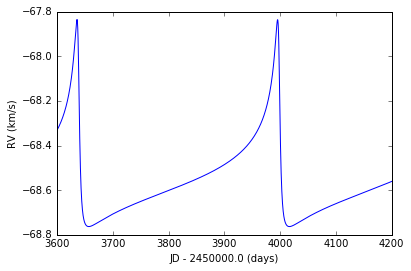

In [3]:
%matplotlib inline
plt.plot(t_sim, rvs)
plt.xlabel('JD - 2450000.0 (days)')
plt.ylabel('RV (km/s)')
plt.show()

There we go! This exoplanet has a very eccentric orbit, and that is what causes these weird radial velocities variation. For objects with less eccentric orbits (more circular), the radial velocities basically look like a senoid.

Well, that was simple enough. But most of what astronomers do is to measure radial velocities (RV) and then trying to infer the orbital parameters of the system from the RV data. Can keppy help us with that? Yes! First, let's create some mock data for the HD 83443 b exoplanetary system. Previous studies have estimated the orbital parameters to be: velocity semi-amplitude $K = 58.1$ km/s, orbital period $T = 2.98565$ days, time of periapse passage $t_0 = 1497.5$ [JD-2.45E6 days], argument of periapse $\omega = 11$ [degrees] and eccentricity $e = 0.013$, with a proper motion $V_Z = 29.027$ km/s, and we consider these values as *truth*. Let's create the true orbit in a similar fashion that we previously did:

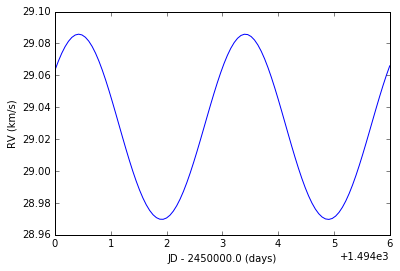

In [51]:
# The "true" parameters
k_true = 58.1E-3
period_true = 2.98565
t0_true = 1497.5
w_true = 11.
e_true = 0.013

# Proper motion and number of points to compute a period of RVs
vz=29.027
nt=1000

ts = np.linspace(1494., 1500., 100)
HD83443 = kepler.BinarySystem(log_k=np.log10(k_true),
                              log_period=np.log10(period_true),
                              t0=t0_true,
                              w=w_true,
                              log_e=np.log10(e_true),
                              vz=vz)
rvs = HD83443.get_rvs(ts=ts, nt=nt)

plt.plot(ts, rvs)
plt.xlabel('JD - 2450000.0 (days)')
plt.ylabel('RV (km/s)')
plt.show()

And now let's "observe" the data by injecting noise to the points:

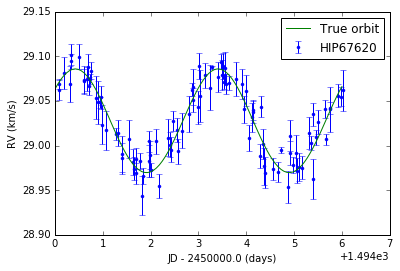

In [52]:
rv_d = np.array([rvk + np.random.normal(loc=0., scale=0.015) for rvk in rvs])
t_d = np.array([tk + np.random.normal(loc=0., scale=0.1) for tk in ts])
rv_derr = np.array([0.015 + np.random.normal(loc=0.0, scale=0.005)
                    for k in rvs])

plt.errorbar(t_d, rv_d, fmt='.', yerr=rv_derr, label="HIP67620")
plt.plot(ts, rvs, label="True orbit")
plt.xlabel('JD - 2450000.0 (days)')
plt.ylabel('RV (km/s)')
plt.legend(numpoints=1)
plt.show()

Okay, now that we have the observation datapoints, let's try to estimate the orbital parameters and see if we can recover their true values from our data. To do that, the most straightforward way with keppy is to use its maximum likelihood estimation routine `ml_orbit`, located inside `estimate`, using the class `OrbitParams`.

We need to provide the routine with a first guess. Since we know the true values of the orbital parameters in the first place, we might as well use them as guess. In practice, we don't know the true values, but we can have an idea just by performing an analysis by eye or something like a periodogram (which provides a first guess for the period, which is probably the most difficult one to estimate by eye).

Then, we run the routine `ml_orbit`. The optional parameters for this function are:
  * `log_k_interval`: it tunes the upper limit for estimating $K$ (default = 2)
  * `t0_interval`: it tunes the lower and upper limits for estimating $t_0$ (default = 100)
  * `maxiter`: maximum number of iterations for the `scipy.minimize` (default = 200)

In [53]:
guess = [np.log10(k_true), np.log10(period_true), t0_true, w_true, np.log10(e_true)]
print('Starting maximum likelihood estimation.')
start_time = time.time()

# We instantiate the class OrbitalParams with our data
estim = estimate.OrbitalParams(t_d, rv_d, rv_derr, vz=vz, guess=guess)

# And run the estimation
params_ml = estim.ml_orbit()
print('Orbital parameters estimation took %.4f seconds' %
      (time.time()-start_time))
print('\nK = %.3f, T = %.2f, t0 = %.1f, w = %.1f, e = %.3f' %
      (10 ** params_ml[0], 10 ** params_ml[1], params_ml[2], 
       params_ml[3], 10 ** params_ml[4]))

Starting maximum likelihood estimation.
Orbital parameters estimation took 0.4491 seconds

K = 0.055, T = 3.00, t0 = 1497.5, w = 11.0, e = 0.013


That hopefully worked quite quickly, since we're working with a well-behaved almost sinusoidal curve of radial velocities. Now, let's compare the estimated orbit with the true one:

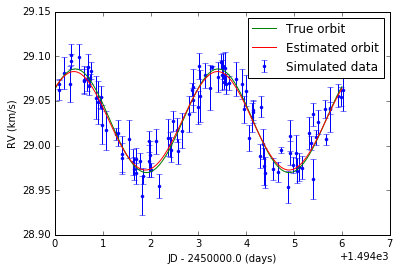

In [54]:
# We compute the estimated orbit

HD83443_est = kepler.BinarySystem(log_k=params_ml[0],
                                  log_period=params_ml[1],
                                  t0=params_ml[2],
                                  w=params_ml[3],
                                  log_e=params_ml[4],
                                  vz=vz)

rv_est = HD83443_est.get_rvs(nt=nt, ts=ts)

# And plot the results
plt.errorbar(t_d, rv_d, fmt='.', yerr=rv_derr, label="Simulated data")
plt.plot(ts, rvs, label="True orbit")
plt.plot(ts, rv_est, label="Estimated orbit")
plt.plot()
plt.xlabel('JD - 2450000.0 (days)')
plt.ylabel('RV (km/s)')
plt.legend(numpoints=1)
plt.show()

And there we have it. The only problem now is to know the uncertainties of our estimation. `ml_orbit` calculates the maximum likelihood values, but it does not compute confidence intervals for our estimated parameters. In order to obtain those, we need a more advanced tool: a MCMC (Markov chain Monte Carlo) sampler. In the case of `keppy`, it uses [`emcee`](http://dan.iel.fm/emcee/current/).

The routine `emcee_orbit` is located inside `estimate`, still using the class `OrbitalParams`, yields the samples that we can then use to obtain the best values and the uncertainties. We use as `guess` the orbital parameters obtained from the maximum likelihood estimation. The parameters `nwalkers` is the number of walkers to be used on `emcee` (default = 20), `nsteps` is the number of steps the walkers will make (default = 1000), and `nthreads` is the number of threads in your computer (default = 1) to be used for multiprocessing. **Be careful when setting nwalkers! If you don't know the number of threads in your machine, set it to 1.** I generally get a 30% better performance when I use the 4 threads in my computer.

This time, we re-instantiate `estimate.OrbitalParameters` with a `bounds` optional parameter, which will serve as the limits for our flat priors (it can also be set for the `ml_orbit` routine). Keep in mind that `emcee_orbit`, as it is setup in the following cell, will take some time to run: it took about a minute in my computer.

In [55]:
estim = estimate.OrbitalParams(t_d, rv_d, rv_derr, vz=vz, guess=params_ml,
                               bounds=((-3, -1),(0, 1),(1490, 1500),(0, 20),(-3, -1)))
start_time = time.time()                                 
samples = estim.emcee_orbit(nwalkers=20,
                            nsteps=5000,
                            nthreads=4)
print('Orbital parameters estimation took %.4f seconds' %
      (time.time()-start_time))

Orbital parameters estimation took 70.0328 seconds


Now we use corner to make the triangle plot for our samples. You will notice that some of them look weird: it seems they are splashed along one axis -- this generally happens when your parameter is not well constrained. In our case, the parameter that is not well constrained is $w$.

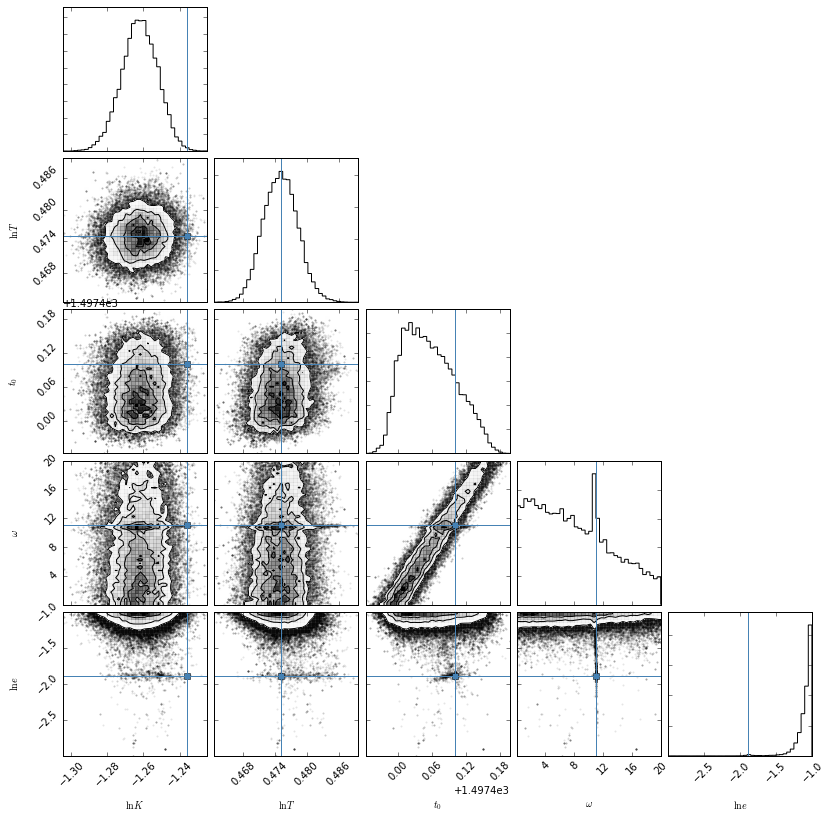

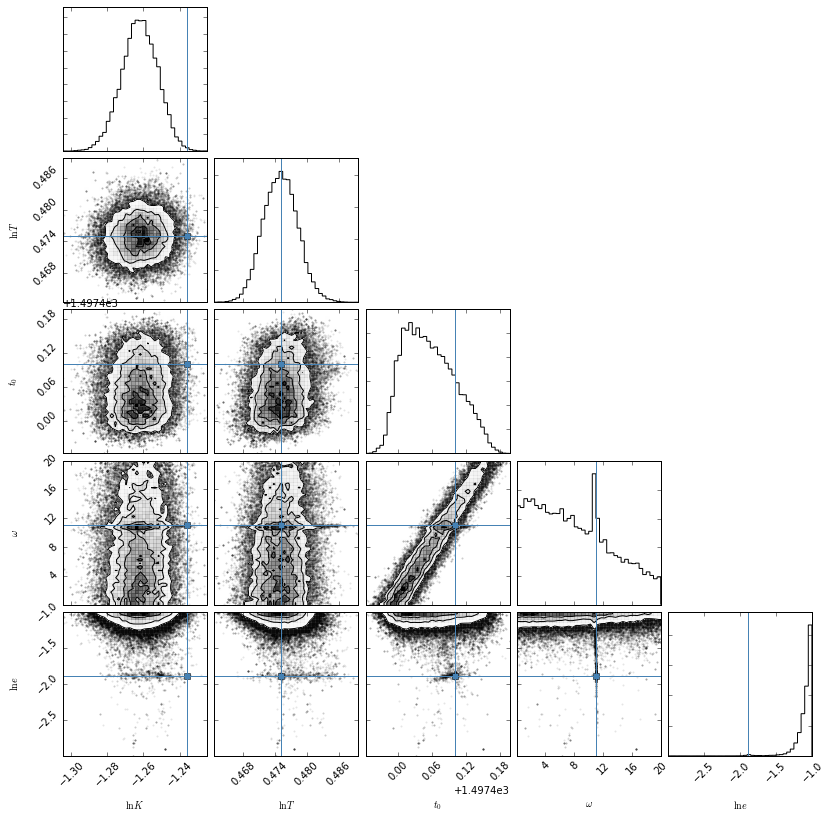

In [56]:
# corner is used to make these funky triangle plots
corner.corner(samples,
              bins=40,
              labels=[r'$\ln{K}$', r'$\ln{T}$', r'$t_0$', r'$\omega$', r'$\ln{e}$'],
              truths=[np.log10(k_true), np.log10(period_true), t0_true, w_true, np.log10(e_true)])

The following cell will transform the log values to linear.

In [ ]:
samples[:,0] = 10 ** samples[:,0]
samples[:,1] = 10 ** samples[:,1]
samples[:,4] = 10 ** samples[:,4]

There are various ways to quote the best values of the orbital parameters from a MCMC sampling. The way we adopt here is to quote the uncertainties based on the 16th, 50th, and 84th percentiles of the samples in the marginalized distributions, like so:

In [58]:
log_k_mcmc, log_period_mcmc, t0_mcmc, w_mcmc, log_e_mcmc = map(lambda v: np.array([v[1], v[2]-v[1], v[1]-v[0]]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
#k_mcmc = 10 ** log_k_mcmc
#period_mcmc = 10 ** log_period_mcmc
#e_mcmc = 10 ** log_e_mcmc
print('K = %.3f + (+ %.3f, -%.3f)' % (log_k_mcmc[0], log_k_mcmc[1], log_k_mcmc[2]))
print('T = %.2f + (+ %.2f, -%.2f)' % (log_period_mcmc[0], log_period_mcmc[1], log_period_mcmc[2])) 
print('t0 = %.1f + (+ %.1f, -%.1f)' % (t0_mcmc[0], t0_mcmc[1], t0_mcmc[2]))
print('w = %.1f + (+ %.1f, -%.1f)' % (w_mcmc[0], w_mcmc[1], w_mcmc[2])) 
print('e = %.3f + (+ %.3f, -%.3f)' % (log_e_mcmc[0], log_e_mcmc[1], log_e_mcmc[2]))

K = 0.055 + (+ 0.001, -0.001)
T = 2.99 + (+ 0.02, -0.02)
t0 = 1497.5 + (+ 0.1, -0.0)
w = 7.4 + (+ 6.5, -5.2)
e = 0.087 + (+ 0.010, -0.019)


Now we can draw values of our parameters from the `emcee` samples and plot them to compare with our data and the "true" values.

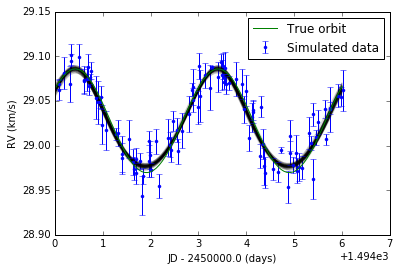

In [59]:
for _K, _T, _t0, _w, _e in samples[np.random.randint(len(samples), size=100)]:
    orbit_est = kepler.BinarySystem(log_k=np.log10(_K),
                                    log_period=np.log10(_T),
                                    t0=_t0,
                                    w=_w,
                                    log_e=np.log10(_e),
                                    vz=vz)
    rv_est = orbit_est.get_rvs(nt=nt, ts=ts)
    plt.plot(ts, rv_est, color="k", alpha=0.1)

# Plotting the results
plt.errorbar(t_d, rv_d, fmt='.', yerr=rv_derr, label="Simulated data")
plt.plot(ts, rvs, label="True orbit")
plt.plot()
plt.xlabel('JD - 2450000.0 (days)')
plt.ylabel('RV (km/s)')
plt.legend(numpoints=1)
plt.show()

Not too shabby!